# Multimodal Diffusion with Discriminator and Encoder Guidance

This notebook implements two approaches for guiding diffusion models in multimodal settings:
1. **Discriminator Guided Diffusion** - Using a classifier/discriminator to guide the generation process
2. **Encoder (InfoNCE) Guided Diffusion** - Using a contrastive learning approach to guide diffusion

We'll use the MNIST dataset with two modalities: original and 90° rotated MNIST digits.

In [ ]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import rotate
import torch.nn.functional as F
import numpy as np
import math
from tqdm import tqdm
from datetime import datetime


In [ ]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
# Define TwoModalMNIST dataset
class TwoModalMNIST(torch.utils.data.Dataset):
    def __init__(self, root, train=True, download=True, angle=0.0, transform=None):
        self.mnist = datasets.MNIST(root=root, train=train, download=download)
        self.angle = angle
        self.transform = transform or transforms.ToTensor()
        self.label_to_indices = {}
        for idx, lbl in enumerate(self.mnist.targets):
            lbl = int(lbl)
            self.label_to_indices.setdefault(lbl, []).append(idx)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, index):
        img1, label = self.mnist[index]
        candidates = self.label_to_indices[label]
        j = index
        while j == index:
            j = random.choice(candidates)
        img2, _ = self.mnist[j]
        img1 = self.transform(img1)
        img2 = rotate(img2, angle=self.angle, fill=0)
        img2 = self.transform(img2)
        return (img1, img2), label



In [ ]:
# Parameters
BATCH_SIZE = 64
ROT_ANGLE = 90.0
IMG_SIZE = 28
T = 1000
beta_start, beta_end = 1e-4, 0.02

# Diffusion schedule parameters
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1. - betas
abar = torch.cumprod(alphas, 0)
sqrt_abar, sqrt_one_mabar = abar.sqrt(), (1-abar).sqrt()

# Normalization transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create data loaders
train_dataset = TwoModalMNIST(root="../data", train=True, download=True, # change depending on data path
                        angle=ROT_ANGLE, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TwoModalMNIST(root="../data", train=False, download=True,
                        angle=ROT_ANGLE, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Used to lood all necessary saved models
root = './results/classifier_guidance_multimodal_mnist/'

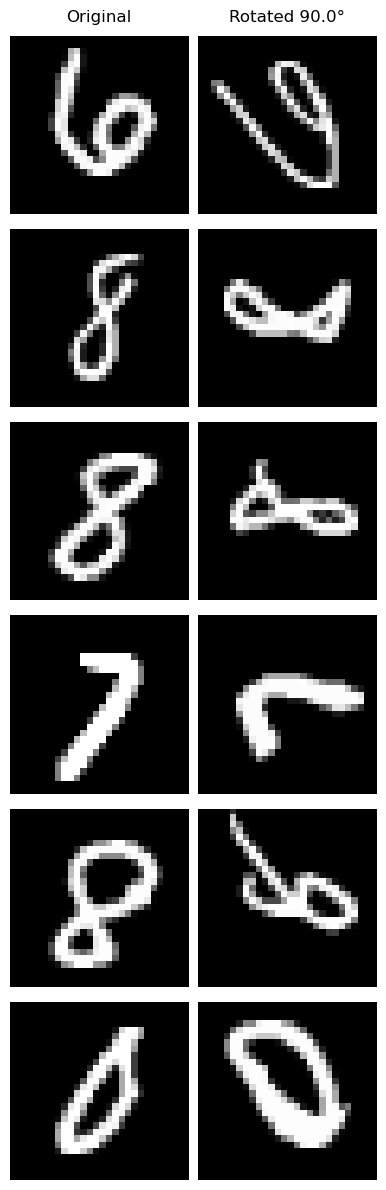

In [6]:
# Visualization helper function
def plot_joint_samples(x1, x2, n=8, modality_names=("A", "B")):
    """
    Show `n` pairs side-by-side.
    `x1`, `x2` are output tensors from `guided_sampling`.
    """
    x1 = x1[:n].cpu().squeeze().numpy()
    x2 = x2[:n].cpu().squeeze().numpy()

    fig, axes = plt.subplots(n, 2, figsize=(4, 2 * n))
    for i in range(n):
        axes[i, 0].imshow(x1[i], cmap="gray", vmin=0, vmax=1)
        axes[i, 0].axis("off")
        axes[i, 1].imshow(x2[i], cmap="gray", vmin=0, vmax=1)
        axes[i, 1].axis("off")
        if i == 0:
            axes[i, 0].set_title(f"Modality {modality_names[0]}")
            axes[i, 1].set_title(f"Modality {modality_names[1]}")
    plt.tight_layout()
    plt.show()

# Show some examples from the dataset
def show_dataset_examples():
    # Fetch one batch
    (batch_orig, batch_rot), labels = next(iter(train_loader))

    # Plot a few samples
    num_pairs = 6
    fig, axes = plt.subplots(num_pairs, 2, figsize=(4, 2 * num_pairs))
    for i in range(num_pairs):
        orig = batch_orig[i].squeeze().numpy()
        rot = batch_rot[i].squeeze().numpy()
        axes[i, 0].imshow(orig, vmin=orig.min(), vmax=orig.max(), cmap="gray")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(rot, vmin=rot.min(), vmax=rot.max(), cmap="gray")
        axes[i, 1].axis('off')

    axes[0, 0].set_title("Original", pad=10)
    axes[0, 1].set_title(f"Rotated {ROT_ANGLE}°", pad=10)
    plt.tight_layout()
    plt.show()

show_dataset_examples()

## 1. Define Model Building Blocks

First, we'll define the UNet model building blocks for our diffusion models.

In [10]:
# UNet building blocks
class ResBlock(nn.Module):
    def __init__(self, c_in, c_out, t_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.SiLU(),
                                 nn.Linear(t_dim, c_out))
        self.block1 = nn.Sequential(
            nn.GroupNorm(8, c_in),
            nn.SiLU(),
            nn.Conv2d(c_in, c_out, 3, 1, 1))
        self.block2 = nn.Sequential(
            nn.GroupNorm(8, c_out),
            nn.SiLU(),
            nn.Conv2d(c_out, c_out, 3, 1, 1))
        self.skip = nn.Conv2d(c_in, c_out, 1) if c_in != c_out else nn.Identity()

    def forward(self, x, t):
        h = self.block1(x)
        h = h + self.mlp(t)[:, :, None, None]
        h = self.block2(h)
        return h + self.skip(x)

class SelfAttention(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.groupnorm = nn.GroupNorm(8, ch)
        self.qkv = nn.Conv2d(ch, ch*3, 1)
        self.proj = nn.Conv2d(ch, ch, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.groupnorm(x)
        q, k, v = self.qkv(h).chunk(3,1)       # each [B,C,H,W]
        q = q.reshape(B, C, -1)                # [B,C,HW]
        k = k.reshape(B, C, -1)
        v = v.reshape(B, C, -1)
        attn = torch.einsum('bci,bcj->bij', q, k) * (C ** -0.5)
        attn = attn.softmax(-1)
        h = torch.einsum('bij,bcj->bci', attn, v).reshape(B, C, H, W)
        return x + self.proj(h)

class BetterUNet(nn.Module):
    """
    28×28 UNet architecture with base_channels=64 and t_dim=128
    """
    def __init__(self, base=64, t_dim=128):
        super().__init__()
        self.t_dim = t_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(t_dim, t_dim*4), nn.SiLU(),
            nn.Linear(t_dim*4, t_dim))

        self.in_conv = nn.Conv2d(1, base, 3, 1, 1)

        # down
        self.down1 = ResBlock(base, base, t_dim)
        self.down2 = ResBlock(base, base*2, t_dim)
        self.attn2 = SelfAttention(base*2)
        self.down3 = ResBlock(base*2, base*4, t_dim)
        self.attn3 = SelfAttention(base*4)
        self.mid   = ResBlock(base*4, base*4, t_dim)

        self.pool = nn.MaxPool2d(2)

        # up
        self.up3 = ResBlock(base*4+base*4, base*2, t_dim)
        self.up2 = ResBlock(base*2+base*2, base,   t_dim)
        self.up1 = ResBlock(base+base,     base,   t_dim)

        self.out = nn.Sequential(
            nn.GroupNorm(8, base),
            nn.SiLU(),
            nn.Conv2d(base, 1, 3, 1, 1))

    # sinusoidal emb → (B, t_dim)
    def t_encoding(self, t):
        half = self.t_dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(half, device=t.device) / half)
        emb = torch.cat([torch.sin(t[:,None]*freqs),
                         torch.cos(t[:,None]*freqs)], 1)
        return self.time_mlp(emb)

    def forward(self, x, t):
        temb = self.t_encoding(t)

        x = self.in_conv(x)          # 28×28

        d1 = self.down1(x, temb)     # 28×28
        d2 = self.down2(self.pool(d1), temb)   # 14×14
        d2 = self.attn2(d2)
        d3 = self.down3(self.pool(d2), temb)   # 7×7
        d3 = self.attn3(d3)

        mid= self.mid(self.pool(d3), temb)     # 3×3

        u3 = F.interpolate(mid, size=d3.shape[-2:])
        u3 = self.up3(torch.cat([u3, d3], 1), temb)

        u2 = F.interpolate(u3, size=d2.shape[-2:])
        u2 = self.up2(torch.cat([u2, d2], 1), temb)

        u1 = F.interpolate(u2, size=d1.shape[-2:])
        u1 = self.up1(torch.cat([u1, d1], 1), temb)

        return self.out(u1)

## 2. Training Diffusion Models

Here we train two separate diffusion models, one for each modality.

In [36]:
def train_diffusion_models(train_loader, epochs=30, save_models=True):
    # Initialize models and optimizers
    denoiserA = BetterUNet().to(device)
    denoiserB = BetterUNet().to(device)
    optA = torch.optim.AdamW(denoiserA.parameters(), lr=2e-4)
    optB = torch.optim.AdamW(denoiserB.parameters(), lr=2e-4)
    
    for epoch in range(epochs):
        denoiserA.train()
        denoiserB.train()
        
        total_lossA = 0
        total_lossB = 0
        num_batches = 0
        
        for (img_clean, img_rot), _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            img_clean = img_clean.to(device)  # [B,1,28,28]
            img_rot = img_rot.to(device)

            # Sample a random timestep for each sample
            bsz = img_clean.size(0)
            t = torch.randint(0, T, (bsz,), device=device).long()

            # Train model A (clean)
            noise = torch.randn_like(img_clean)
            # q(x_t | x0)
            x_t = sqrt_abar[t][:,None,None,None] * img_clean + \
                  sqrt_one_mabar[t][:,None,None,None] * noise

            pred_noise = denoiserA(x_t, t.float())
            lossA = F.mse_loss(pred_noise, noise)

            optA.zero_grad()
            lossA.backward()
            optA.step()
            
            # Train model B (rotated)
            noise2 = torch.randn_like(img_rot)
            x_t2 = sqrt_abar[t][:,None,None,None] * img_rot + \
                  sqrt_one_mabar[t][:,None,None,None] * noise2

            pred_noise2 = denoiserB(x_t2, t.float())
            lossB = F.mse_loss(pred_noise2, noise2)

            optB.zero_grad()
            lossB.backward()
            optB.step()
            
            total_lossA += lossA.item()
            total_lossB += lossB.item()
            num_batches += 1
        
        print(f'Epoch {epoch+1} Loss A: {total_lossA/num_batches:.4f} Loss B: {total_lossB/num_batches:.4f}')
        
    if save_models:
        torch.save(denoiserA.state_dict(), "denoiser_mnist.pth")
        torch.save(denoiserB.state_dict(), "denoiser_rot_mnist.pth")
    
    return denoiserA, denoiserB

# Comment out to skip training - you can load pretrained models instead
# denoiserA, denoiserB = train_diffusion_models(train_loader)



In [35]:
# Load pretrained models
denoiserA = BetterUNet().to(device)
denoiserB = BetterUNet().to(device)
denoiserA.load_state_dict(torch.load(f"{root}/denoiser_mnist_epoch60.pth", map_location=device)) 
denoiserB.load_state_dict(torch.load(f"{root}/denoiser_rot_mnist_epoch60.pth", map_location=device))
denoiserA.eval()
denoiserB.eval()
print('ok')

ok


/tmp/ipykernel_497069/1706308278.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoiserA.load_state_dict(torch.load(f"{root}/denoiser_mnist_epoch60.pth", map_location=

## 3. Unconditional Sampling

First, let's see how the models generate samples without any guidance.

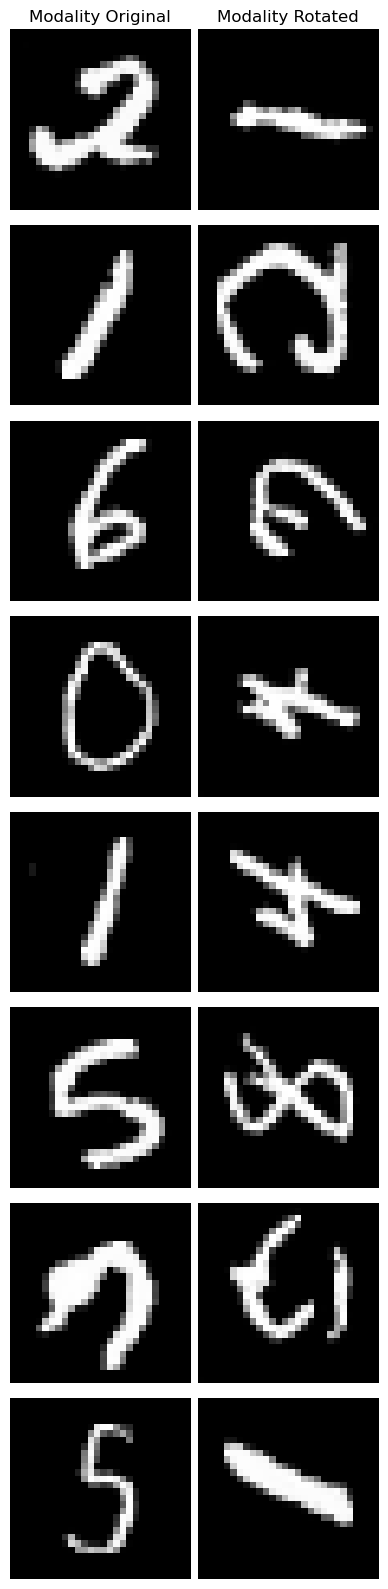

In [15]:
@torch.no_grad()
def sample_diffusion(model, num_samples, device):
    """
    Generate `num_samples` images from the DDPM defined by `model`.
    Returns a tensor [num_samples,1,IMG_SIZE,IMG_SIZE] in [0,1].
    """
    model.eval()
    # Start from pure noise (in *normalized* space)
    x = torch.randn(num_samples, 1, IMG_SIZE, IMG_SIZE, device=device)

    for t in reversed(range(T)):
        t_index = torch.full((num_samples,), t, device=device).float()
        # Predict noise
        eps_theta = model(x, t_index)

        # Coefficients
        alpha_t = alphas[t]
        beta_t = betas[t]
        sqrt_alpha_t = torch.sqrt(alpha_t)
        coef1 = 1.0 / sqrt_alpha_t
        coef2 = (1 - alpha_t) / torch.sqrt(1 - abar[t])

        # Mean of p(x_{t-1} | x_t)
        x = coef1 * (x - coef2 * eps_theta)

        # Add noise except at t=0
        if t > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = x + sigma_t * noise

    # Now x is in the *normalized* range; unnormalize back to [0,1]
    # Using the MNIST stats from the transforms
    mean, std = 0.1307, 0.3081
    x = x * std + mean
    return x.clamp(0, 1)

# Generate samples from each model independently
samplesA = sample_diffusion(denoiserA, 8, device)
samplesB = sample_diffusion(denoiserB, 8, device)

# Plot the independent samples
plot_joint_samples(samplesA, samplesB, modality_names=("Original", "Rotated"))

## 4. Discriminator-Guided Diffusion

Now, we'll implement Discriminator-Guided Diffusion:
1. Create a contrastive dataset for training the discriminator
2. Define the discriminator architecture
3. Train the discriminator
4. Implement guided sampling using the discriminator

In [21]:
# 1. Create Discriminator Dataset (Positive and Negative Pairs)
class RandomMNIST(torch.utils.data.Dataset):
    def __init__(self, base_dataset, neg_prob=0.5):
        self.base_dataset = base_dataset
        self.neg_prob = neg_prob
        self.all_labels = list(self.base_dataset.label_to_indices.keys())

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        # Get positive pair
        (img1, img2), label = self.base_dataset[index]

        # Generate negative sample with probability neg_prob
        if random.random() < self.neg_prob:
            rand_idx = random.randrange(len(self.base_dataset.mnist))
            img2, _ = self.base_dataset.mnist[rand_idx]
            img2 = rotate(img2, angle=self.base_dataset.angle, fill=0)
            img2 = self.base_dataset.transform(img2)
            target = torch.tensor(0.0)  # Negative pair
        else:
            target = torch.tensor(1.0)  # Positive pair

        return (img1, img2), target

# Create datasets for discriminator training
rd_train_dataset = RandomMNIST(train_dataset)
rd_test_dataset = RandomMNIST(test_dataset)

rd_train_loader = DataLoader(rd_train_dataset, batch_size=256, shuffle=True)
rd_test_loader = DataLoader(rd_test_dataset, batch_size=256, shuffle=False)

In [52]:
import math, torch
import torch.nn as nn
from torchvision.transforms.functional import rotate


class FeatureExtractor(nn.Module):
    def __init__(self, base, t_dim):
        super().__init__()
        self.conv1   = nn.Conv2d(1, base, 3, 1, 1)
        self.res1    = ResBlock(base,   base,   t_dim)
        self.pool1   = nn.MaxPool2d(2)
        self.res2    = ResBlock(base,   base*2, t_dim)
        self.attn1   = SelfAttention(base*2)
        self.pool2   = nn.MaxPool2d(2)
        self.res3    = ResBlock(base*2, base*4, t_dim)
        self.attn2   = SelfAttention(base*4)
        self.pool3   = nn.MaxPool2d(2)
        self.gpool   = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x, temb):
        x = self.conv1(x)
        x = self.res1(x, temb)
        x = self.pool1(x)
        x = self.res2(x, temb)
        x = self.attn1(x)
        x = self.pool2(x)
        x = self.res3(x, temb)
        x = self.attn2(x)
        x = self.pool3(x)
        x = self.gpool(x)
        return x

class DiscriminatorMultimodal(nn.Module):
    def __init__(self, base=64, t_dim=128):
        super().__init__()
        self.t_dim = t_dim

        # time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(t_dim, t_dim*4),
            nn.SiLU(),
            nn.Linear(t_dim*4, t_dim),
        )

        # two *independent* feature extractors
        self.feature_extractor1 = FeatureExtractor(base, t_dim)
        self.feature_extractor2 = FeatureExtractor(base, t_dim)

        # final combiner
        self.combiner = nn.Sequential(
            nn.Linear(base*4*2, base*2),
            nn.SiLU(),
            nn.Linear(base*2, base),
            nn.SiLU(),
            nn.Linear(base, 1),
            # remove this Sigmoid if you’re using BCEWithLogitsLoss
            # nn.Sigmoid()
        )

    def t_encoding(self, t):
        half = self.t_dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half, device=t.device) / half)
        emb = torch.cat([
            torch.sin(t[:, None] * freqs),
            torch.cos(t[:, None] * freqs)
        ], dim=1)
        return self.time_mlp(emb)

    def forward(self, x1, x2, t):
        temb  = self.t_encoding(t)
        f1    = self.feature_extractor1(x1, temb).flatten(1)
        f2    = self.feature_extractor2(x2, temb).flatten(1)
        combined = torch.cat([f1, f2], dim=1)
        return self.combiner(combined).squeeze(-1)


In [53]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm

def train_discriminator(
    discriminator,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=10,
    save_every=10,
    root='./results/classifier_guidance_multimodal_mnist/discriminator'
):
    """
    Trains the multimodal discriminator, evaluates on val_loader each epoch,
    and saves the model every `save_every` epochs (and at the final epoch).
    
    Args:
        discriminator: nn.Module
        train_loader: DataLoader for training
        val_loader:   DataLoader for validation
        optimizer:    torch.optim.Optimizer
        device:       torch.device
        num_epochs:   int, total epochs to train
        save_every:   int, save every k epochs
        save_path_template: str, format string for checkpoint paths,
            e.g. '/models/disc_epoch_{epoch}.pth'
    """
    date_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    # curriculum = NoiseCurriculum(num_epochs, T)
    # criterion  = nn.BCELoss()
    criterion = nn.BCEWithLogitsLoss()
    discriminator.to(device)

    for epoch in range(1, num_epochs + 1):
        # — TRAIN —
        discriminator.train()
        # curriculum.update()

        train_loss, train_correct, train_total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"[Epoch {epoch}/{num_epochs}] Train")
        for (img1, img2), target in pbar:
            img1, img2 = img1.to(device), img2.to(device)
            target = target.float().to(device)
            b = img1.size(0)

            # curriculum‐based timesteps
            # t = torch.randint(0, curriculum.current_max_t + 1, (b,), device=device).long()
            t = torch.randint(0, T, (b,), device=device).long()

            # add noise
            noise1, noise2 = torch.randn_like(img1), torch.randn_like(img2)
            sqrt_a    = sqrt_abar[t].view(-1,1,1,1)
            sqrt_1_ma = sqrt_one_mabar[t].view(-1,1,1,1)
            noisy1 = sqrt_a * img1 + sqrt_1_ma * noise1
            noisy2 = sqrt_a * img2 + sqrt_1_ma * noise2

            # forward + loss
            preds = discriminator(noisy1, noisy2, t.float())
            loss  = criterion(preds, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss   += loss.item() * b
            train_correct+= (nn.Sigmoid()(preds) > 0.5).float().eq(target).sum().item()
            train_total  += b
            pbar.set_postfix({
                "loss": f"{train_loss/train_total:.4f}",
                "acc":  f"{train_correct/train_total:.4f}",
                # "max_t": curriculum.current_max_t
            })

        # — VALIDATION —
        discriminator.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"[Epoch {epoch}/{num_epochs}] Val  ")
            for (img1, img2), target in pbar:
                img1, img2 = img1.to(device), img2.to(device)
                target = target.float().to(device)
                b = img1.size(0)

                # for validation we can sample across full T
                t = torch.randint(0, T, (b,), device=device).long()

                noise1, noise2 = torch.randn_like(img1), torch.randn_like(img2)
                sqrt_a    = sqrt_abar[t].view(-1,1,1,1)
                sqrt_1_ma = sqrt_one_mabar[t].view(-1,1,1,1)
                noisy1 = sqrt_a * img1 + sqrt_1_ma * noise1
                noisy2 = sqrt_a * img2 + sqrt_1_ma * noise2

                preds = discriminator(noisy1, noisy2, t.float())
                loss  = criterion(preds, target)

                val_loss    += loss.item() * b
                val_correct += (nn.Sigmoid()(preds) > 0.5).float().eq(target).sum().item()
                val_total   += b
                pbar.set_postfix({
                    "val_loss": f"{val_loss/val_total:.4f}",
                    "val_acc":  f"{val_correct/val_total:.4f}"
                })

        # — EPOCH SUMMARY —
        train_acc = train_correct / train_total
        val_acc   = val_correct   / val_total
        print(
            f"Epoch {epoch} Summary: "
            f"Train Loss: {train_loss/train_total:.4f}, "
            f"Train Acc: {train_acc:.4f} — "
            f"Val Loss: {val_loss/val_total:.4f}, "
            f"Val Acc: {val_acc:.4f}"
        )

        # — SAVE CHECKPOINT —
        if epoch % save_every == 0 or epoch == num_epochs:
            ckpt_path = root+f'/{date_str}/discriminator_multimodal_{epoch}.pth'
            os.makedirs(os.path.dirname(ckpt_path) or '.', exist_ok=True)
            torch.save(discriminator.state_dict(), ckpt_path)
            print(f"Saved model checkpoint to {ckpt_path}")

    return discriminator


In [ ]:
if False: # set to true to train discriminator
    root = f'./results/classifier_guidance_multimodal_mnist/discriminator'

    # Initialize and train the discriminator
    epochs= 30 
    discriminator = DiscriminatorMultimodal().to(device)
    optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
    
    # Train the discriminator
    discriminator = train_discriminator(discriminator, rd_train_loader, rd_test_loader, optimizer, device, num_epochs=epochs,
                                       root=  root )

In [27]:
# Load pre-trained diffusion models
denoiserA = BetterUNet().to(device)
denoiserB = BetterUNet().to(device)
discriminator = DiscriminatorMultimodal().to(device)
# Load the pre-trained weights
root = "./results/classifier_guidance_multimodal_mnist"
denoiserA.load_state_dict(torch.load(root+"/denoiser_mnist_epoch60.pth", map_location=device, weights_only=True))
denoiserB.load_state_dict(torch.load(root+"/denoiser_rot_mnist_epoch60.pth", map_location=device, weights_only=True))
discriminator.load_state_dict(torch.load(f"{root}/logits/discriminator_multimodal_30.pth", map_location=device, weights_only=True))

# Set to evaluation mode
denoiserA.eval()
denoiserB.eval()
discriminator.eval()
print('ok')

ok


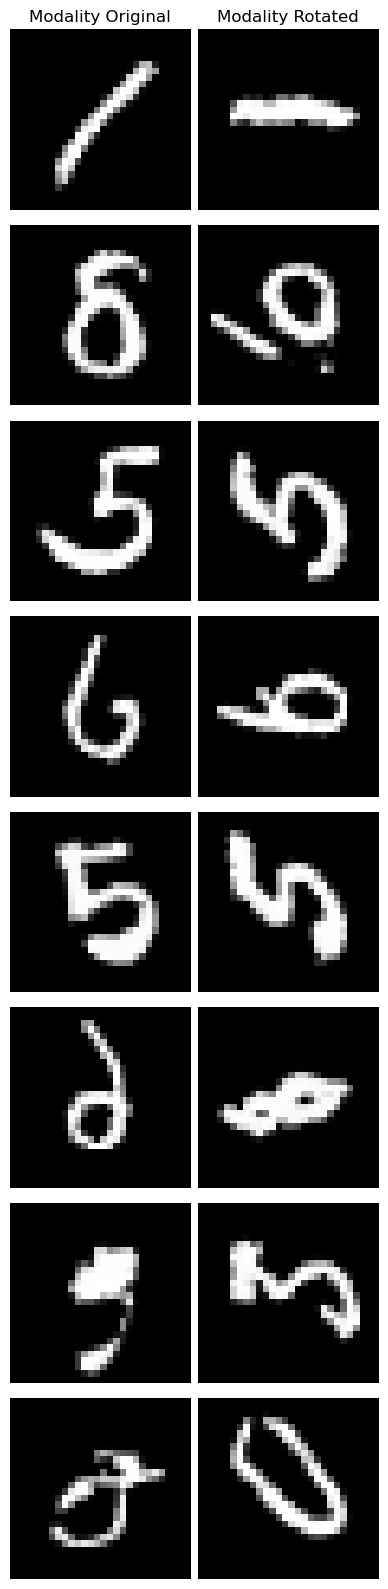

In [28]:
# 4. Discriminator-Guided Sampling
def guided_sampling(
    diffusionA, diffusionB, discriminator,
    betas,                          # 1-D tensor of length T
    num_samples=8,
    guidance_scale=4.0,          # Guidance strength
    device="cuda",
):
    """Joint discriminator-guided sampling to produce matched pairs"""
    T = betas.size(0)
    alphas = 1.0 - betas
    abar = torch.cumprod(alphas, dim=0)
    sqrt_abar = abar.sqrt()
    sqrt_one_minus_abar = (1 - abar).sqrt()

    # Start from noise
    x1 = torch.randn(num_samples, 1, 28, 28, device=device)
    x2 = torch.randn_like(x1)

    diffusionA.eval()
    diffusionB.eval()
    discriminator.eval()

    for t in tqdm(reversed(range(T)), total = T):
        t_batch = torch.full((num_samples,), t, dtype=torch.long, device=device)

        # 1) Get noise predictions from each diffusion model
        with torch.no_grad():
            eps1 = diffusionA(x1, t_batch)
            eps2 = diffusionB(x2, t_batch)

        # 2) Compute discriminator gradient
        x1.requires_grad_(True)
        x2.requires_grad_(True)
        logits = discriminator(x1, x2, t_batch).squeeze() 
        logp = torch.log(torch.sigmoid(logits) + 1e-8).sum()
        grad_x1, grad_x2 = torch.autograd.grad(logp, (x1, x2))
        # Cut out the graph
        x1 = x1.detach()
        x2 = x2.detach()

        # 3) Combine scores
        sigma_t = sqrt_one_minus_abar[t]
        eps1 = eps1 - guidance_scale * sigma_t * grad_x1
        eps2 = eps2 - guidance_scale * sigma_t * grad_x2

        # 4) DDPM posterior update
        with torch.no_grad():
            beta_t = betas[t]
            alpha_t = alphas[t]
            abar_t = abar[t]
            abar_prev = abar[t-1] if t > 0 else torch.tensor(1.0, device=device)

            # Predict x0
            x0_pred1 = (x1 - sigma_t * eps1) / sqrt_abar[t]
            x0_pred2 = (x2 - sigma_t * eps2) / sqrt_abar[t]

            # Posterior mean coefficients
            coef1 = beta_t * abar_prev.sqrt() / (1 - abar_t)
            coef2 = (1 - abar_prev) * alpha_t.sqrt() / (1 - abar_t)

            mean1 = coef1 * x0_pred1 + coef2 * x1
            mean2 = coef1 * x0_pred2 + coef2 * x2

            # Add noise except at t=0
            if t > 0:
                var = beta_t * (1 - abar_prev) / (1 - abar_t)
                std = var.sqrt()
                noise1 = torch.randn_like(x1)
                noise2 = torch.randn_like(x2)
                x1 = mean1 + std * noise1
                x2 = mean2 + std * noise2
            else:
                x1 = mean1
                x2 = mean2

    # Scale to [0,1]
    mean, std = 0.1307, 0.3081
    x1 = (x1 * std + mean).clamp(0, 1)
    x2 = (x2 * std + mean).clamp(0, 1)
    
    return x1, x2

# Generate samples with discriminator guidance
disc_guided_samples_1, disc_guided_samples_2 = guided_sampling(
    denoiserA, denoiserB, discriminator, 
    betas, 
    num_samples=8, 
    guidance_scale=5.0, 
    device=device
)

# Plot the guided samples
plot_joint_samples(disc_guided_samples_1, disc_guided_samples_2, 
                   modality_names=("Original", "Rotated"))

## 5. Encoder (InfoNCE) Guided Diffusion

Now we'll implement the InfoNCE-based encoder guidance:
1. Define the encoder architecture
2. Train with contrastive learning (InfoNCE loss)
3. Implement encoder guidance for sampling

In [56]:
# 1. Define the Encoder Architecture
class FeatureExtractor(nn.Module):
    """Feature extractor for the encoder, returns a feature vector"""
    def __init__(self, base, t_dim, embed_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base, 3, 1, 1)
        self.res1 = ResBlock(base, base, t_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.res2 = ResBlock(base, base*2, t_dim)
        self.attn1 = SelfAttention(base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.res3 = ResBlock(base*2, base*4, t_dim)
        self.attn2 = SelfAttention(base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.gpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(base*4, embed_dim, bias=False)

    def forward(self, x, temb):
        x = self.conv1(x)
        x = self.res1(x, temb)
        x = self.pool1(x)
        x = self.res2(x, temb)
        x = self.attn1(x)
        x = self.pool2(x)
        x = self.res3(x, temb)
        x = self.attn2(x)
        x = self.pool3(x)
        x = self.gpool(x).flatten(1)
        return self.fc(x)                       # (B, embed_dim)

class TimeEmbedding(nn.Module):
    """Sinusoidal + 2-layer MLP time embedding"""
    def __init__(self, t_dim):
        super().__init__()
        self.t_dim = t_dim
        self.mlp = nn.Sequential(
            nn.Linear(t_dim, t_dim*4), nn.SiLU(), nn.Linear(t_dim*4, t_dim)
        )
        # Build sin table
        half = t_dim // 2
        self.register_buffer('freqs', torch.exp(-math.log(10000)*torch.arange(half)/half))

    def forward(self, t):         # t shape (B,)
        freqs = self.freqs.to(t.device)
        emb = torch.cat([torch.sin(t[:,None]*freqs), torch.cos(t[:,None]*freqs)], dim=1)
        return self.mlp(emb)

class EncoderMM(nn.Module):
    """Two-tower encoder returning f(x1), g(x2)"""
    def __init__(self, base=64, t_dim=128, embed_dim=256):
        super().__init__()
        self.time_enc = TimeEmbedding(t_dim)
        self.f_net = FeatureExtractor(base, t_dim, embed_dim)
        self.g_net = FeatureExtractor(base, t_dim, embed_dim)
        self.tau = 0.07                            # InfoNCE temperature

    def forward(self, x1, x2, t):
        temb = self.time_enc(t)
        f = self.f_net(x1, temb)                    # (B,d)
        g = self.g_net(x2, temb)                    # (B,d)
        # L2 normalize for cosine similarities (stabilizes training)
        f = nn.functional.normalize(f, dim=-1)
        g = nn.functional.normalize(g, dim=-1)
        return f, g

In [58]:
# 2. Train the Encoder with InfoNCE Loss
def train_encoder_infoNCE(encoder, loader, device, num_epochs=10, T=1000, lr=2e-4, log_every=100, 
                          save_model=True, root = './results/classifier_guidance_multimodal_mnist/encoder'):
    date_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    """Train encoder with InfoNCE loss"""
    optim = torch.optim.AdamW(encoder.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    encoder.to(device)

    for epoch in range(1, num_epochs+1):
        encoder.train()
        total_loss, total_samples = 0.0, 0
        for step, ((x1,x2), _) in enumerate(tqdm(loader, desc=f"Epoch {epoch}/{num_epochs}")):
            x1, x2 = x1.to(device), x2.to(device)
            B = x1.size(0)
            t = torch.randint(0, T, (B,), device=device).long()

            # Add forward DDPM noise
            noise1, noise2 = torch.randn_like(x1), torch.randn_like(x2)
            sqrt_a = sqrt_abar[t].view(-1,1,1,1)
            sqrt_1_ma = sqrt_one_mabar[t].view(-1,1,1,1)
            x1_t = sqrt_a * x1 + sqrt_1_ma * noise1
            x2_t = sqrt_a * x2 + sqrt_1_ma * noise2

            f, g = encoder(x1_t, x2_t, t.float())       # (B,d) each
            logits = (f @ g.T) / encoder.tau            # (B,B)
            targets = torch.arange(B, device=device)
            loss = criterion(logits, targets)

            optim.zero_grad()
            loss.backward()
            optim.step()
            
            total_loss += loss.item()*B
            total_samples += B

            if (step+1) % log_every == 0:
                print(f"Epoch {epoch} step {step+1}: NCE={total_loss/total_samples:.4f}")
                
        # Calculate accuracy at end of epoch
        with torch.no_grad():
            correct = 0
            total = 0
            for ((x1,x2), _) in disc_test_loader:
                x1, x2 = x1.to(device), x2.to(device)
                B = x1.size(0)
                t = torch.randint(0, T, (B,), device=device).long()
                
                noise1, noise2 = torch.randn_like(x1), torch.randn_like(x2)
                sqrt_a = sqrt_abar[t].view(-1,1,1,1)
                sqrt_1_ma = sqrt_one_mabar[t].view(-1,1,1,1)
                x1_t = sqrt_a * x1 + sqrt_1_ma * noise1
                x2_t = sqrt_a * x2 + sqrt_1_ma * noise2
                
                f, g = encoder(x1_t, x2_t, t.float())
                logits = (f @ g.T) / encoder.tau
                preds = logits.argmax(dim=1)
                correct += (preds == torch.arange(B, device=device)).sum().item()
                total += B
            
            print(f"Epoch {epoch} InfoNCE accuracy: {correct/total:.4f}")
    
    if save_model:
        torch.save(encoder.state_dict(), f"{root}/{date_str}/encoder_{num_epochs}.pth")
    
    return encoder

# Comment out to skip training - you can load pretrained model instead
# encoder = train_encoder_infoNCE(EncoderMM(), train_loader, device, num_epochs=10)



In [ ]:
if False: #set True to train
    root = f'./results/classifier_guidance_multimodal_mnist/encoder'
    encoder = train_encoder_infoNCE(EncoderMM(), train_loader, device, num_epochs=10)

In [38]:
# Load pretrained encoder
encoder = EncoderMM().to(device)
encoder.load_state_dict(torch.load(f"{root}/encoder/enc_epoch_10.pth", map_location=device))
encoder.eval()
print('ok')

ok


/tmp/ipykernel_497069/427124908.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(f"{root}/encoder/enc_epoch_10.pth", map_location=devic

100%|██████████| 1000/1000 [00:31<00:00, 32.21it/s]


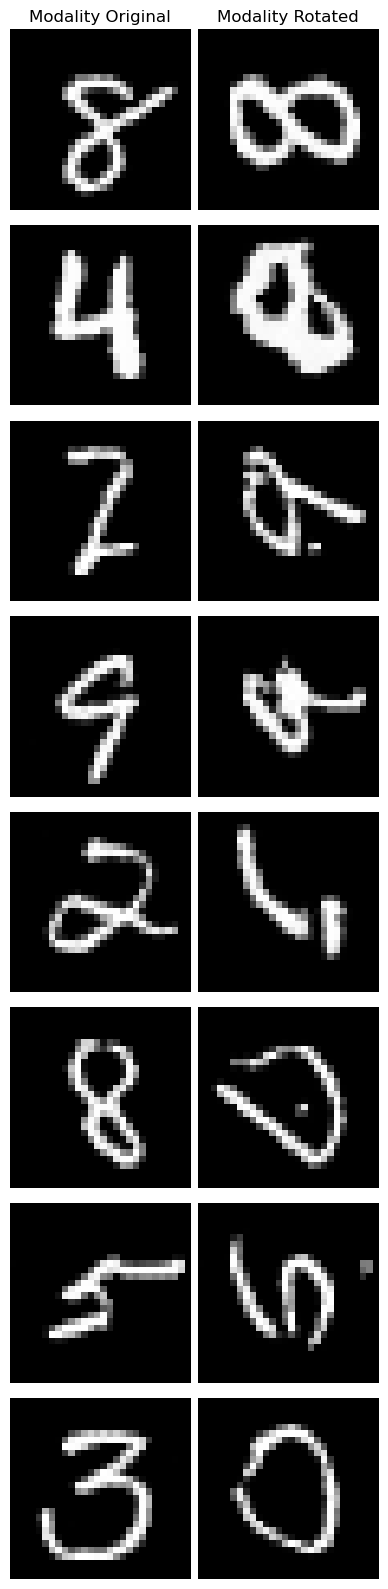

In [41]:
# 3. Encoder-Guided Sampling
def enc_guided_multimodal_sample(net1, net2, encoder, num_samples=8, lam=2.0):
    """
    Generate samples from two frozen DDPMs guided by an InfoNCE encoder.
    
    net1, net2  : frozen noise-prediction networks for x1 and x2
    encoder     : trained EncoderMM (eval mode)
    lam         : guidance strength λ
    """
    net1.eval()
    net2.eval()
    encoder.eval()
    
    x = torch.randn(num_samples, 1, IMG_SIZE, IMG_SIZE, device=device)
    y = torch.randn_like(x)
    tau = encoder.tau

    for t in tqdm(reversed(range(T)), total = T):
        t_idx = torch.full((num_samples,), t, device=device, dtype=torch.long)

        # Base diffusion scores (no grad)
        with torch.no_grad():
            eps_x = net1(x, t_idx)
            eps_y = net2(y, t_idx)

        # Encoder gradient (only part that needs autodiff each step)
        xg = x.detach().requires_grad_(True)
        yg = y.detach().requires_grad_(True)
        f, g = encoder(xg, yg, t_idx.float())          # (B,d) each
        score_enc = (f * g).sum() / tau
        grad_x, grad_y = torch.autograd.grad(score_enc, (xg, yg))

        # Convert encoder gradient to noise-prediction scale
        grad_x = grad_x * torch.sqrt(1 - abar[t])
        grad_y = grad_y * torch.sqrt(1 - abar[t])

        eps_x = eps_x - lam * grad_x
        eps_y = eps_y - lam * grad_y

        # DDPM reverse update
        alpha_t = alphas[t]
        beta_t = betas[t]
        sqrt_alpha_t = torch.sqrt(alpha_t)
        coef1 = 1.0 / sqrt_alpha_t
        coef2 = (1 - alpha_t) / torch.sqrt(1 - abar[t])

        with torch.no_grad():
            x = coef1 * (x - coef2 * eps_x)
            y = coef1 * (y - coef2 * eps_y)
            if t > 0:
                noise = torch.randn_like(x)
                sigma_t = torch.sqrt(beta_t)
                x += sigma_t * noise
                y += sigma_t * noise

    mean, std = 0.1307, 0.3081
    return (x*std+mean).clamp(0,1), (y*std+mean).clamp(0,1)

# Generate samples with encoder guidance
enc_guided_samples_1, enc_guided_samples_2 = enc_guided_multimodal_sample(
    denoiserA, denoiserB, encoder, 
    num_samples=8, 
    lam=4.0
)

# Plot the encoder-guided samples
plot_joint_samples(enc_guided_samples_1, enc_guided_samples_2, 
                   modality_names=("Original", "Rotated"))

## 6. Comparison of Methods

Let's compare the results from different methods:
1. Independent Sampling (no guidance)
2. Discriminator-Guided Sampling
3. Encoder-Guided Sampling

In [47]:
print('num params encoder :', count_parameters(encoder))
print('num params discrim :', count_parameters(discriminator))

num params encoder : 3486208
num params discrim : 3429121


100%|██████████| 1000/1000 [00:31<00:00, 31.64it/s]


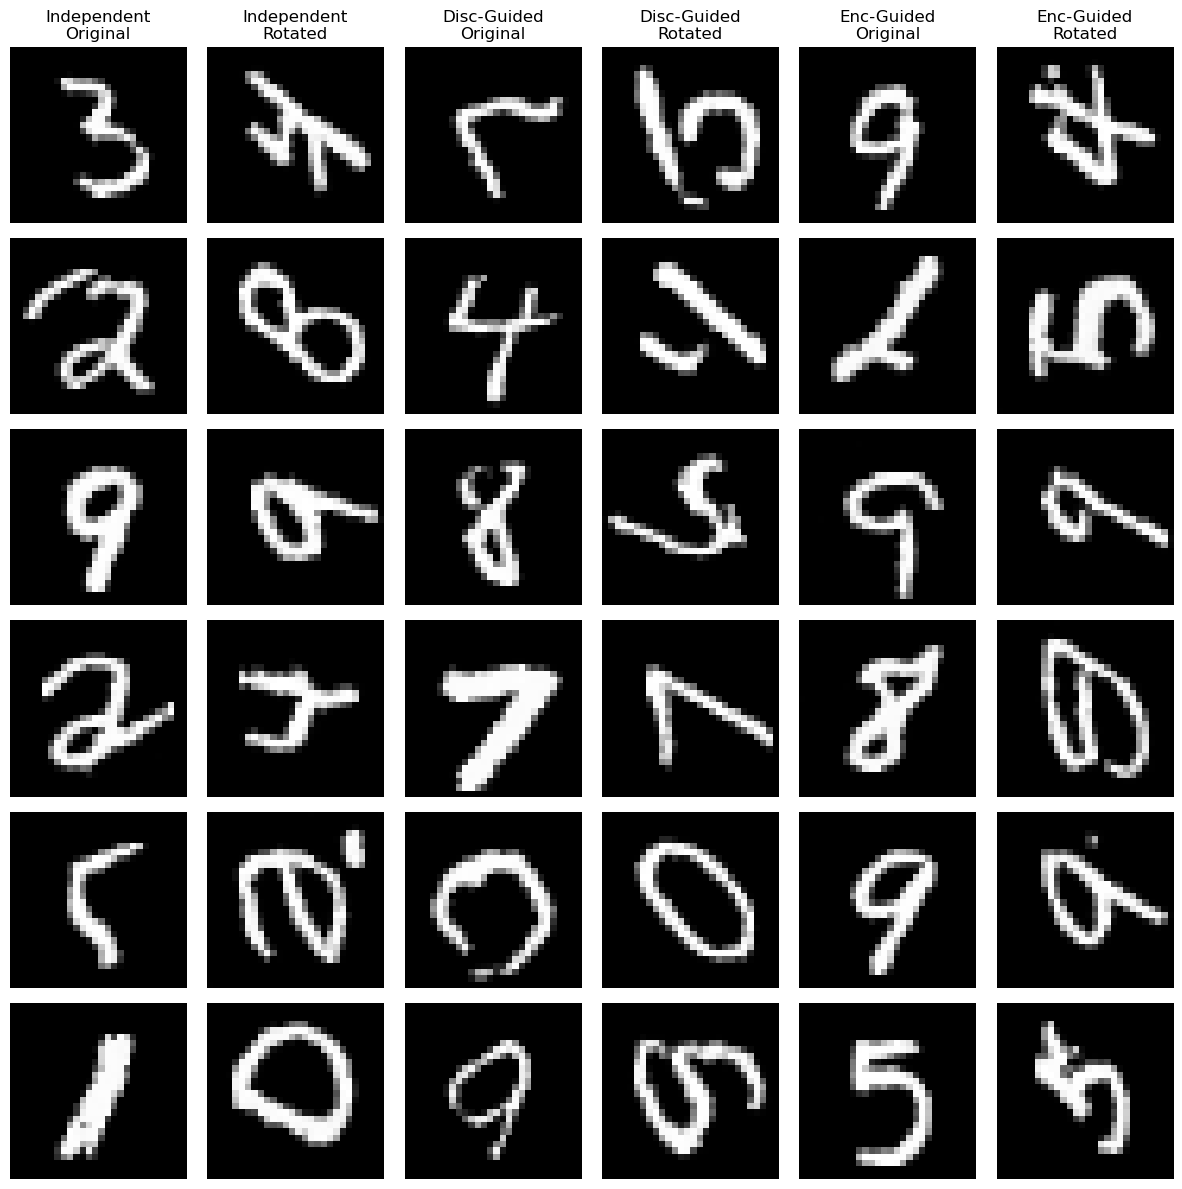

In [42]:
# Generate samples with different methods
num_samples = 6

# Independent sampling
indep_samples_1 = sample_diffusion(denoiserA, num_samples, device)
indep_samples_2 = sample_diffusion(denoiserB, num_samples, device)

# Discriminator-guided sampling
disc_guided_samples_1, disc_guided_samples_2 = guided_sampling(
    denoiserA, denoiserB, discriminator, 
    betas, 
    num_samples=num_samples, 
    guidance_scale=5.0, 
    device=device
)

# Encoder-guided sampling
enc_guided_samples_1, enc_guided_samples_2 = enc_guided_multimodal_sample(
    denoiserA, denoiserB, encoder, 
    num_samples=num_samples, 
    lam=4.0
)

# Plot comparative results
fig, axes = plt.subplots(num_samples, 6, figsize=(12, 2*num_samples))

for i in range(num_samples):
    # Independent samples
    axes[i, 0].imshow(indep_samples_1[i].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(indep_samples_2[i].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[i, 1].axis('off')
    
    # Discriminator-guided samples
    axes[i, 2].imshow(disc_guided_samples_1[i].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[i, 2].axis('off')
    axes[i, 3].imshow(disc_guided_samples_2[i].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[i, 3].axis('off')
    
    # Encoder-guided samples
    axes[i, 4].imshow(enc_guided_samples_1[i].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[i, 4].axis('off')
    axes[i, 5].imshow(enc_guided_samples_2[i].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[i, 5].axis('off')

# Add column titles
if num_samples > 0:
    axes[0, 0].set_title("Independent\nOriginal")
    axes[0, 1].set_title("Independent\nRotated")
    axes[0, 2].set_title("Disc-Guided\nOriginal")
    axes[0, 3].set_title("Disc-Guided\nRotated")
    axes[0, 4].set_title("Enc-Guided\nOriginal")
    axes[0, 5].set_title("Enc-Guided\nRotated")

plt.tight_layout()
plt.show()